In [1]:
import matplotlib

from sectional_v2.data_info import get_nice_name_case
from sectional_v2.util.imports.import_fields_xr_v2 import import_constants
from sectional_v2.util.imports.get_fld_fixed import get_field_fixed
from useful_scit.imps import (np, xr, plt, pd)

# load and autoreload
from IPython import get_ipython

# noinspection PyBroadException
from sectional_v2.util.naming_conventions import var_info
from sectional_v2.util.naming_conventions.var_info import get_fancy_var_name

try:
    _ipython = get_ipython()
    _magic = _ipython.magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass

/home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV/
/home/ubuntu/mnts/nird/projects/OAS-DEV/sectional_v2/data_info/area_defs.csv
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = 'NorESM' 

In [3]:

from sectional_v2.constants import get_plotpath
from sectional_v2.util.practical_functions import make_folders

plot_path = get_plotpath('comparison') + '/scatter/'
print(plot_path)
make_folders(plot_path)

/home/ubuntu/mnts/nird/projects//Plots_OAS-DEV/global_comparison//scatter/


In [4]:
from_time = '2008-01'
to_time = '2008-12'
pmin = 850.  # minimum pressure level
avg_over_lev = True  # True#True#False#True
pressure_adjust = False  # Can only be false if avg_over_lev false. Plots particular hybrid sigma lev
#if avg_over_lev:
#    pressure_adjust = True
p_levels = [1013.,900., 800., 700., 600.]  # used if not avg

lev_lim =100.

In [5]:

cases_sec = ['SECTv21_ctrl_koagD']#, 'PD_SECT_CHC7_diurnal']  # Sect ac eq.20, corr NPF diam, fxdt, vdiam, 1.5xBVOC']
cases_orig = ['noSECTv21_ox_ricc_dd']  # , 'Original eq.18','Original eq.20, 1.5xBVOC','Original eq.20, rednuc']
#cases_orig = ['noSECTv21_default_dd']  # , 'Original eq.18','Original eq.20, 1.5xBVOC','Original eq.20, rednuc']
cases = cases_orig + cases_sec

In [6]:
var_subl = ['NCONC01', 'H2SO4','SOA_LV','N_AER','COAGNUCL','NUCLRATE','GR','PBLH']#,'SOA_NA','SO4_NA']

In [7]:
var1 = var_subl[0]
var2 = var_subl[1]
cases_dic ={}
for case in cases:
    dummy = get_field_fixed(case,
                            var_subl,
                            from_time, to_time,
                            pressure_adjust=pressure_adjust)
    print(dummy)
    ds_constants = import_constants(case)
    
    dummy = xr.merge([dummy, ds_constants])
    cases_dic[case] = dummy.copy()

<xarray.DataArray 'time' (time: 12)>
array([396., 425., 456., 486., 517., 547., 578., 609., 639., 670., 700., 731.])
Coordinates:
  * time     (time) float64 396.0 425.0 456.0 486.0 ... 639.0 670.0 700.0 731.0
Attributes:
    long_name:  time
    units:      days since 2007-01-01 00:00:00
    calendar:   gregorian
    bounds:     time_bnds
<xarray.DataArray 'time' (time: 12)>
array(['2008-01-17T00:00:00.000000000', '2008-02-15T00:00:00.000000000',
       '2008-03-17T00:00:00.000000000', '2008-04-16T00:00:00.000000000',
       '2008-05-17T00:00:00.000000000', '2008-06-16T00:00:00.000000000',
       '2008-07-17T00:00:00.000000000', '2008-08-17T00:00:00.000000000',
       '2008-09-16T00:00:00.000000000', '2008-10-17T00:00:00.000000000',
       '2008-11-16T00:00:00.000000000', '2008-12-17T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2008-01-17 2008-02-15 ... 2008-12-17
Attributes:
    long_name:  time
    bounds:     time_bnds
Returnin

In [8]:
# select values close to surface:
for case in cases:
    _ds = cases_dic[case]
    _ds = _ds.sel(lev=slice(lev_lim,None))#sel(lev=slice(20,None))
    cases_dic[case] = _ds

In [9]:
for var in ['H2SO4','SOA_LV']:
    for case in cases:
        _ds = cases_dic[case]
        _ds.load()
        if _ds[var].units=='mol/mol':
            _ds[var] = _ds[var]*1e12
            _ds[var].attrs['units']='ppt'
var = var1

dummy
case_sec = cases_sec[0]
case_orig = cases_orig[0]
ds_diff = (cases_dic[case_sec]- cases_dic[case_orig])#.isel(lev=slice(20,None))
for var in var_subl:
    ds_diff[var+'_'+case_sec] = cases_dic[case_sec][var]#.isel(lev=slice(20,None))
    ds_diff[var+'_'+case_orig] = cases_dic[case_orig][var]#.isel(lev=slice(20,None))
ds_diff.load()
for var in var_subl:
    for case in cases:
        ds_diff[f'log{var}_{case}'] = np.log10(ds_diff[f'{var}_{case}'])#+'_'+ case_orig])
    ds_diff[f'log{var}_diff'] = ds_diff[f'log{var}_{case_sec}'] -ds_diff[f'log{var}_{case_orig}']

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


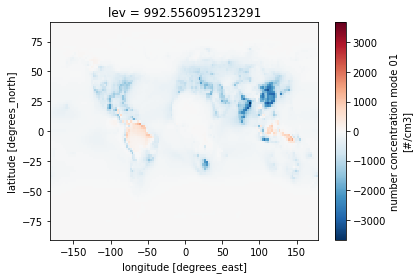

In [21]:
ds_diff['NCONC01'].mean('time').isel(lev=-1).plot()
plt.show()

In [22]:
ds_diff.to_netcdf('test.nc')

In [23]:
ds_diff= xr.open_dataset('test.nc')

In [24]:
vars_inc = ['NCONC01','logNCONC01_noSECTv21_ox_ricc_dd','logGR_noSECTv21_ox_ricc_dd','logNUCLRATE_noSECTv21_ox_ricc_dd',
            'logCOAGNUCL_noSECTv21_ox_ricc_dd','logH2SO4_noSECTv21_ox_ricc_dd',
           'logSOA_LV_noSECTv21_ox_ricc_dd']
vars_an =vars_inc[1:]
#['NCONC01_noSECTv21_ox_ricc_dd','logGR_noSECTv21_ox_ricc_dd','logNUCLRATE_noSECTv21_ox_ricc_dd',
#            'logCOAGNUCL_noSECTv21_ox_ricc_dd','logH2SO4_noSECTv21_ox_ricc_dd',
#           'logSOA_LV_noSECTv21_ox_ricc_dd']
_da = ds_diff[vars_inc]#.to_array()#,sample_dims=['test'])

In [25]:
_das = _da.stack(z = ('lat','lon','lev','time'))

In [26]:
_df = _das.to_dataframe()

In [27]:
_sss = _df['logNCONC01_noSECTv21_ox_ricc_dd']==np.inf

_sss.unique()

array([False])

In [28]:
def clean_nan(df):
    for col in df.columns:
        df=df[df[col].notnull()]
        df = df[df[col] != np.inf]
        df = df[df[col] != -np.inf]
    return df
_df = clean_nan(_df)

In [29]:
_df['NCONC_cat'] = pd.qcut(_df['NCONC01'], q=4)

In [30]:
from sklearn.preprocessing import StandardScaler
x = _df.loc[:, vars_an].values
x = StandardScaler().fit_transform(x) # normalizing the features

In [31]:
x.shape

(2975245, 6)

In [32]:
x.shapecase_orig

AttributeError: 'numpy.ndarray' object has no attribute 'shapecase_orig'

In [ ]:
np.mean(x),np.std(x)

In [ ]:
feat_cols = [va.split('_')[0] for va in vars_an]
#]]#'feature'+str(i) for i in range(x.shape[1])]

In [ ]:
feat_cols

In [25]:
normalised_breast = pd.DataFrame(x,columns=feat_cols)

In [26]:
normalised_breast#.std()

,logNCONC01,logGR,logNUCLRATE,logCOAGNUCL,logH2SO4,logSOA
0,-0.664264,-4.312797,-0.487566,-0.990082,-4.378149,-4.167206
1,-0.669869,-4.433560,0.311400,-1.003101,-4.535748,-3.756202
2,-0.678082,-4.240520,0.361635,-1.020069,-4.309245,-3.009419
3,-0.716455,-3.377873,0.162770,-1.066213,-3.263596,-2.967691
4,-0.689395,-2.504465,-0.117696,-1.030794,-2.203813,-2.473392
...,...,...,...,...,...,...
2975240,-1.242416,0.968376,-0.365171,-1.538088,-0.867719,1.228043
2975241,-1.769852,0.399376,-0.558688,-1.826511,-1.146214,0.926942
2975242,-4.088257,-0.633309,-1.157872,-2.708926,-1.029467,-0.182898
2975243,-3.467987,0.020954,-0.950643,-1.871035,-0.210214,-0.590841


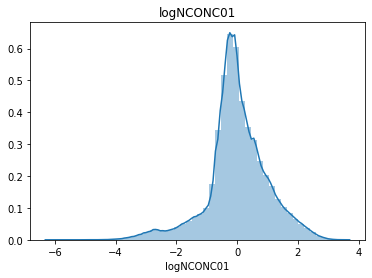

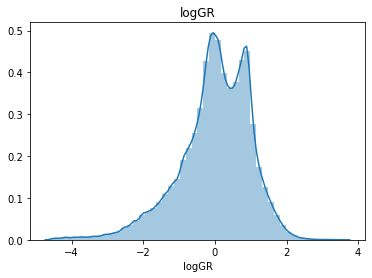

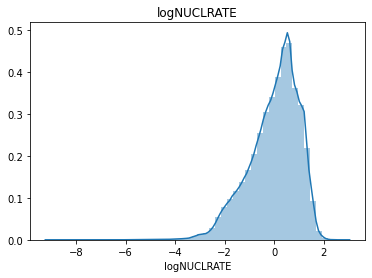

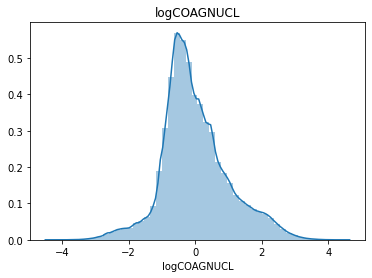

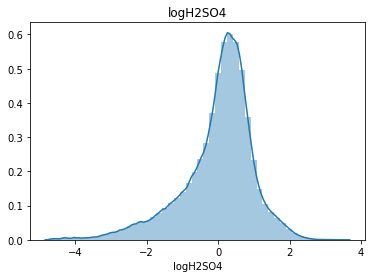

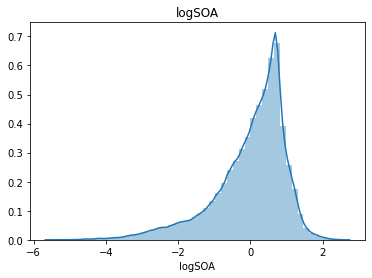

In [27]:
import seaborn as sns
for col in normalised_breast.columns:
    sns.distplot(normalised_breast[col])
    plt.title(col)
    plt.show()

In [28]:
mean_vec = np.mean(x, axis=0)
cov_mat = (x - mean_vec).T.dot((x - mean_vec)) / (x.shape[0]-1)

In [29]:
cov_mat

array([[1.00000101, 0.54143811, 0.41218145, 0.89234975, 0.6380988 ,
        0.11286885],
       [0.54143811, 0.99999731, 0.17912835, 0.56219011, 0.88193573,
        0.69807296],
       [0.41218145, 0.17912835, 1.0000005 , 0.24557477, 0.34374809,
        0.09576613],
       [0.89234975, 0.56219011, 0.24557477, 1.00000109, 0.55446137,
        0.13855714],
       [0.6380988 , 0.88193573, 0.34374809, 0.55446137, 1.00000168,
        0.48734961],
       [0.11286885, 0.69807296, 0.09576613, 0.13855714, 0.48734961,
        1.00000084]])

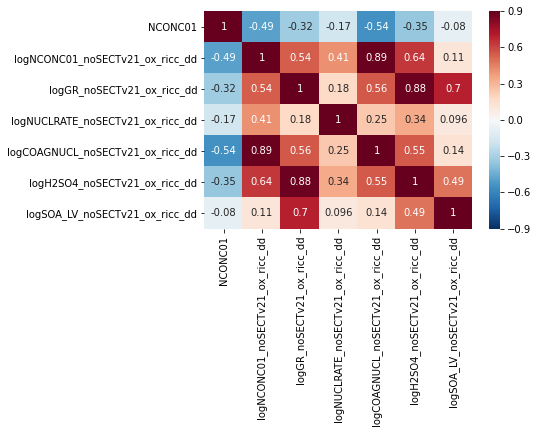

In [30]:
corrMatrix = _df.corr()
sns.heatmap(corrMatrix, annot=True, cmap='RdBu_r', vmin=-.9, vmax=.9)
plt.show()

## Above q75

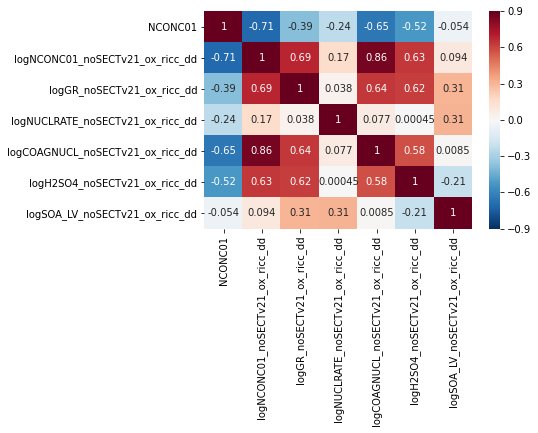

In [32]:
va = _df.logNCONC01_noSECTv21_ox_ricc_dd
ma = va>va.quantile(.75) 
corrMatrix = _df[ma].corr()
sns.heatmap(corrMatrix, annot=True, cmap='RdBu_r', vmin=-.9, vmax=.9)
plt.show()

##  q25

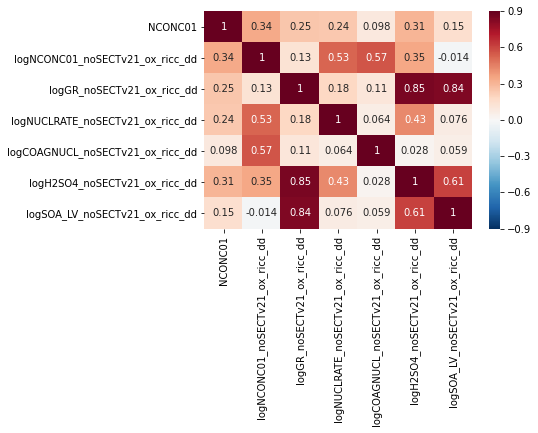

In [33]:
va = _df.logNCONC01_noSECTv21_ox_ricc_dd
ma = va<va.quantile(.25) 
corrMatrix = _df[ma].corr()
sns.heatmap(corrMatrix, annot=True, cmap='RdBu_r', vmin=-.9, vmax=.9)
plt.show()

In [297]:
corrMatrix.loc['NCONC01']

NCONC01                             1.000000
logNCONC01_noSECTv21_ox_ricc_dd     0.344115
logGR_noSECTv21_ox_ricc_dd          0.248801
logNUCLRATE_noSECTv21_ox_ricc_dd    0.242750
logCOAGNUCL_noSECTv21_ox_ricc_dd    0.097739
logH2SO4_noSECTv21_ox_ricc_dd       0.305146
logSOA_LV_noSECTv21_ox_ricc_dd      0.147962
Name: NCONC01, dtype: float64

In [48]:
va = 10**_df.logNCONC01_noSECTv21_ox_ricc_dd
qs = va.quantile([0,.10,.20,.30,.40,.50,.60,.70,.80,.85,.90,.95,1.00])
quant_corr = pd.DataFrame(index=vars_inc)
for i in range(len(qs)-1):
    ma = (qs.iloc[i]<=va)&(va<qs.iloc[i+1])
    c_m = _df[ma].corr()
    quant_corr[qs.iloc[i+1]] = c_m.loc['NCONC01']
    #quant_corr.append_row
    
#ma = va<va.quantile(.25) 

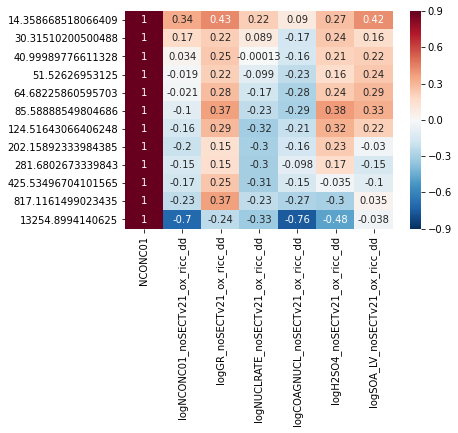

In [49]:
sns.heatmap(quant_corr.transpose(), annot=True, cmap='RdBu_r', vmin=-.9, vmax=.9)
plt.show()

Text(0, 0.5, 'corr Na, X ')

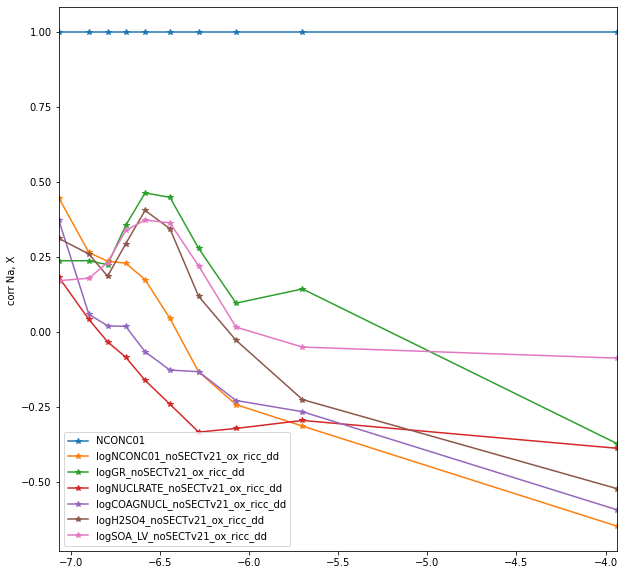

In [316]:
fig, ax = plt.subplots(1,figsize=[10,10])
quant_corr.transpose().plot(ax = ax, marker='*')
ax.set_ylabel('corr Na, X ')

In [62]:
from sklearn.decomposition import PCA
pca_breast = PCA(n_components=3)
principalComponents_breast = pca_breast.fit_transform(x)

In [61]:
from sklearn.decomposition import PCA
pca_breast = PCA(n_components=0.9)#n_components=2)
principalComponents_breast = pca_breast.fit(x)

In [52]:
pca_breast.n_components_

3

In [63]:
pca_breast.explained_variance_ratio_

array([0.56905081, 0.21138857, 0.13897482])

In [64]:
pca_breast.components_[0]

array([-0.45035732, -0.48158246, -0.23743564, -0.43137193, -0.4869185 ,
       -0.29276246], dtype=float32)

In [67]:
pca_breast.components_[1]

array([ 0.42278054, -0.34306487,  0.33713448,  0.36373335, -0.14050981,
       -0.6617091 ], dtype=float32)

logNCONC01_noSECTv21_ox_ricc_dd 0
[-0.45035732, -0.45035732]
[0.42278054, 0.42278054]
[0.17075154, 0.17075154]


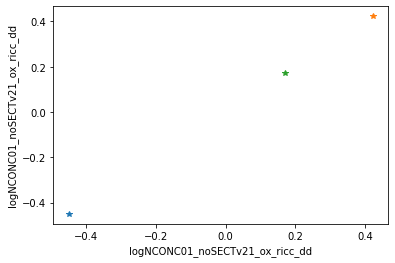

[-0.45035732, -0.48158246]
[0.42278054, -0.34306487]
[0.17075154, 0.09107723]


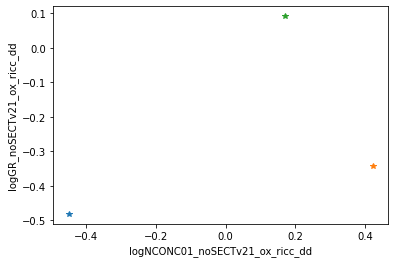

[-0.45035732, -0.23743564]
[0.42278054, 0.33713448]
[0.17075154, -0.88817185]


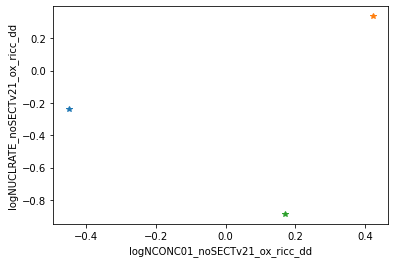

[-0.45035732, -0.43137193]
[0.42278054, 0.36373335]
[0.17075154, 0.37584767]


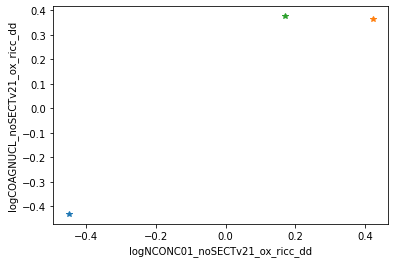

[-0.45035732, -0.4869185]
[0.42278054, -0.14050981]
[0.17075154, -0.04267738]


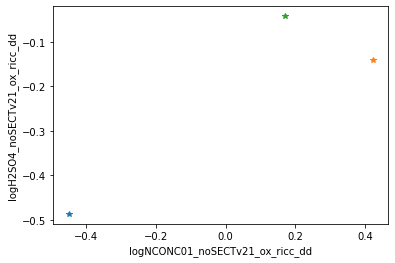

[-0.45035732, -0.29276246]
[0.42278054, -0.6617091]
[0.17075154, -0.17497659]


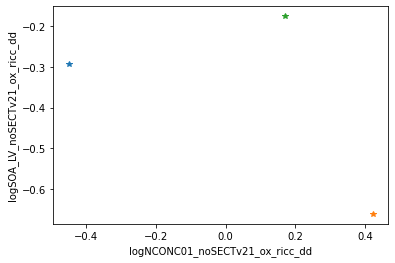

logGR_noSECTv21_ox_ricc_dd 1
[-0.48158246, -0.45035732]
[-0.34306487, 0.42278054]
[0.09107723, 0.17075154]


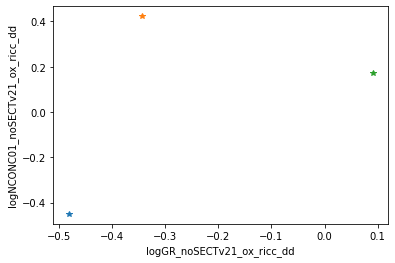

[-0.48158246, -0.48158246]
[-0.34306487, -0.34306487]
[0.09107723, 0.09107723]


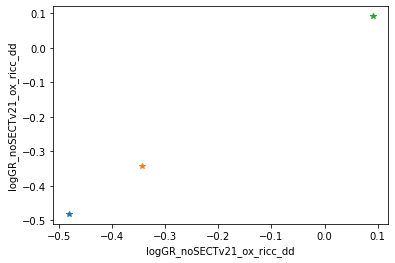

[-0.48158246, -0.23743564]
[-0.34306487, 0.33713448]
[0.09107723, -0.88817185]


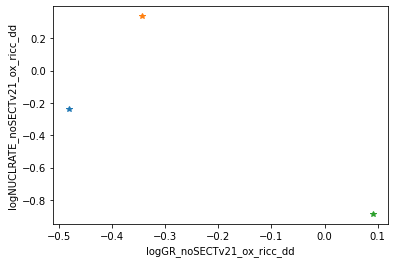

[-0.48158246, -0.43137193]
[-0.34306487, 0.36373335]
[0.09107723, 0.37584767]


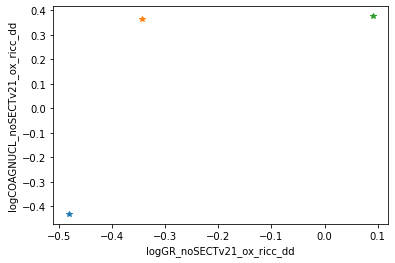

[-0.48158246, -0.4869185]
[-0.34306487, -0.14050981]
[0.09107723, -0.04267738]


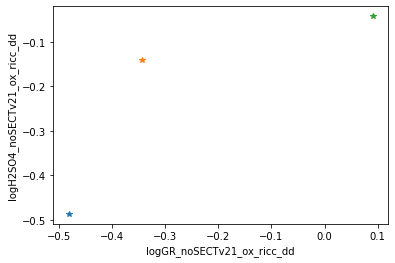

[-0.48158246, -0.29276246]
[-0.34306487, -0.6617091]
[0.09107723, -0.17497659]


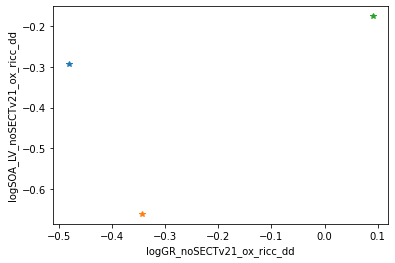

logNUCLRATE_noSECTv21_ox_ricc_dd 2
[-0.23743564, -0.45035732]
[0.33713448, 0.42278054]
[-0.88817185, 0.17075154]


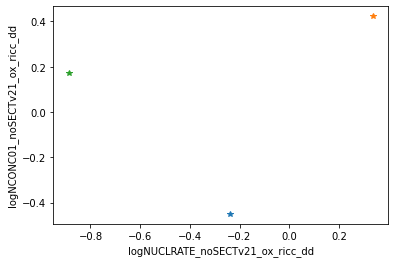

[-0.23743564, -0.48158246]
[0.33713448, -0.34306487]
[-0.88817185, 0.09107723]


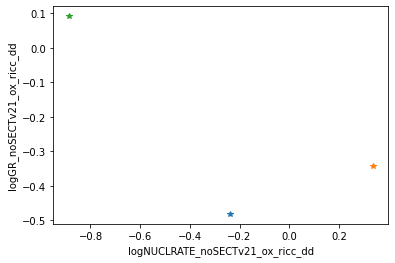

[-0.23743564, -0.23743564]
[0.33713448, 0.33713448]
[-0.88817185, -0.88817185]


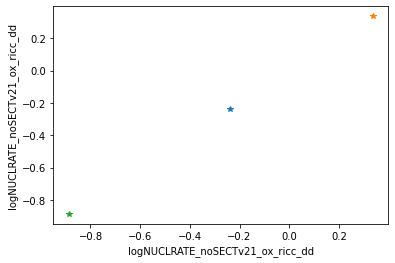

[-0.23743564, -0.43137193]
[0.33713448, 0.36373335]
[-0.88817185, 0.37584767]


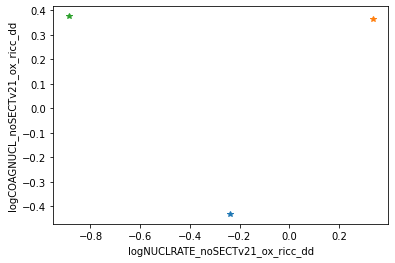

[-0.23743564, -0.4869185]
[0.33713448, -0.14050981]
[-0.88817185, -0.04267738]


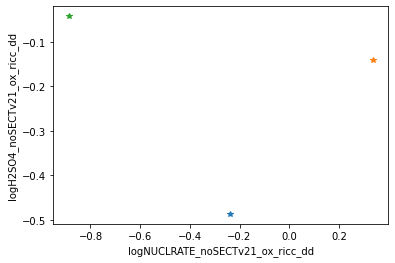

[-0.23743564, -0.29276246]
[0.33713448, -0.6617091]
[-0.88817185, -0.17497659]


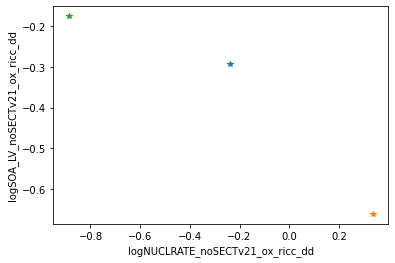

logCOAGNUCL_noSECTv21_ox_ricc_dd 3
[-0.43137193, -0.45035732]
[0.36373335, 0.42278054]
[0.37584767, 0.17075154]


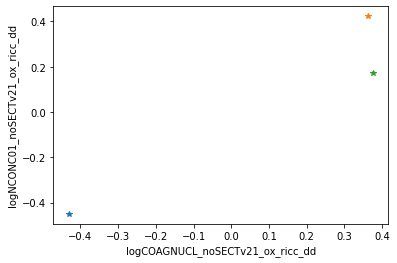

[-0.43137193, -0.48158246]
[0.36373335, -0.34306487]
[0.37584767, 0.09107723]


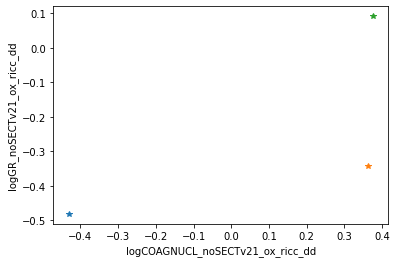

[-0.43137193, -0.23743564]
[0.36373335, 0.33713448]
[0.37584767, -0.88817185]


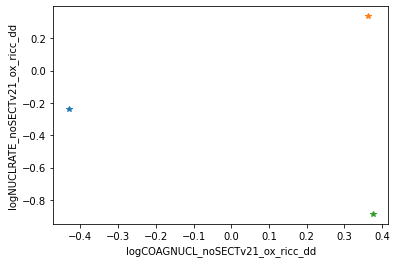

[-0.43137193, -0.43137193]
[0.36373335, 0.36373335]
[0.37584767, 0.37584767]


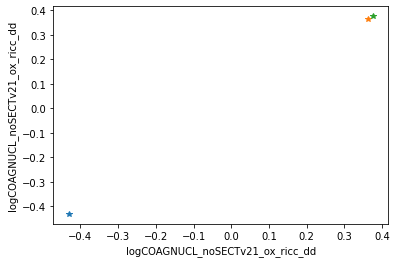

[-0.43137193, -0.4869185]
[0.36373335, -0.14050981]
[0.37584767, -0.04267738]


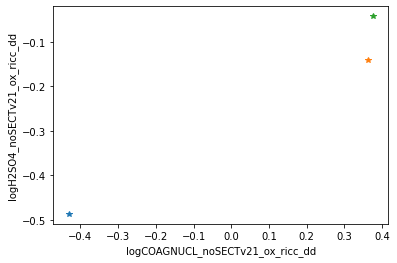

[-0.43137193, -0.29276246]
[0.36373335, -0.6617091]
[0.37584767, -0.17497659]


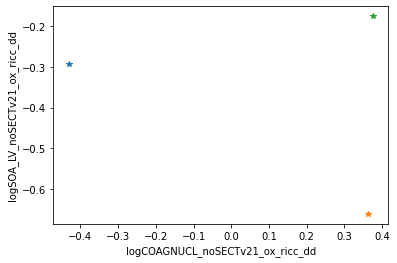

logH2SO4_noSECTv21_ox_ricc_dd 4
[-0.4869185, -0.45035732]
[-0.14050981, 0.42278054]
[-0.04267738, 0.17075154]


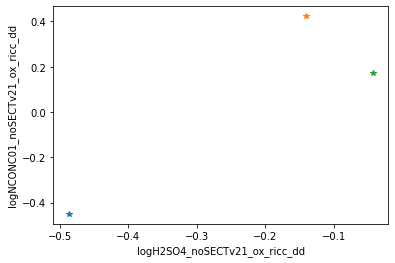

[-0.4869185, -0.48158246]
[-0.14050981, -0.34306487]
[-0.04267738, 0.09107723]


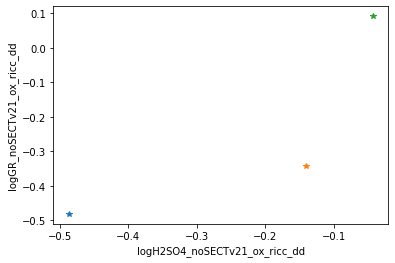

[-0.4869185, -0.23743564]
[-0.14050981, 0.33713448]
[-0.04267738, -0.88817185]


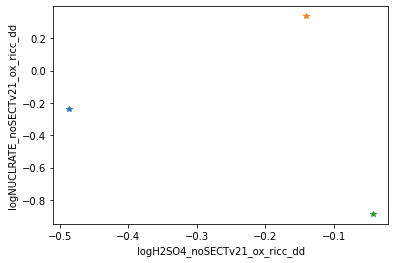

[-0.4869185, -0.43137193]
[-0.14050981, 0.36373335]
[-0.04267738, 0.37584767]


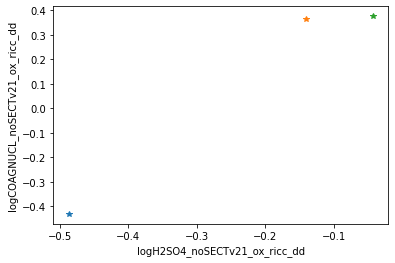

[-0.4869185, -0.4869185]
[-0.14050981, -0.14050981]
[-0.04267738, -0.04267738]


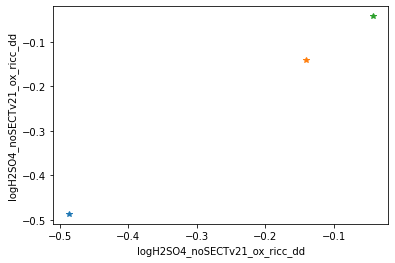

[-0.4869185, -0.29276246]
[-0.14050981, -0.6617091]
[-0.04267738, -0.17497659]


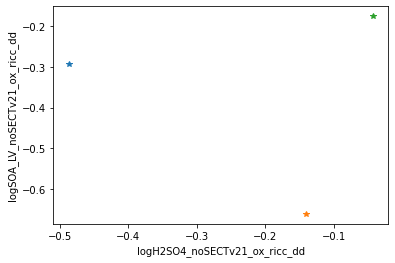

logSOA_LV_noSECTv21_ox_ricc_dd 5
[-0.29276246, -0.45035732]
[-0.6617091, 0.42278054]
[-0.17497659, 0.17075154]


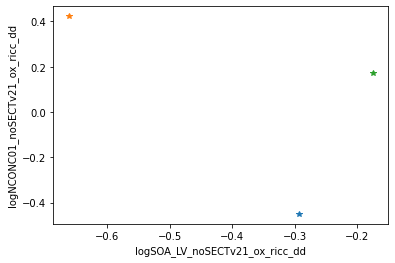

[-0.29276246, -0.48158246]
[-0.6617091, -0.34306487]
[-0.17497659, 0.09107723]


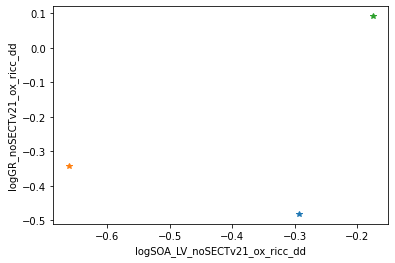

[-0.29276246, -0.23743564]
[-0.6617091, 0.33713448]
[-0.17497659, -0.88817185]


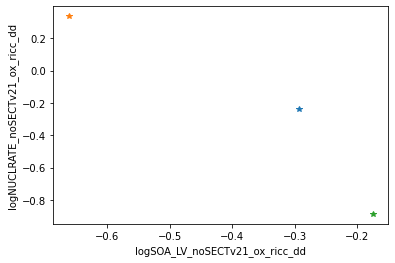

[-0.29276246, -0.43137193]
[-0.6617091, 0.36373335]
[-0.17497659, 0.37584767]


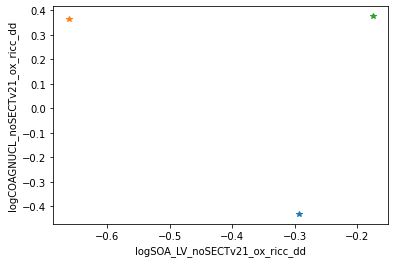

[-0.29276246, -0.4869185]
[-0.6617091, -0.14050981]
[-0.17497659, -0.04267738]


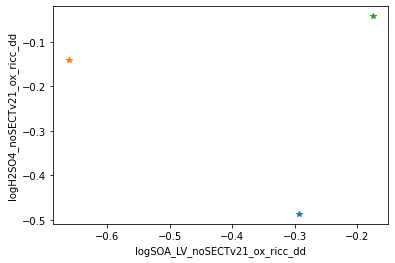

[-0.29276246, -0.29276246]
[-0.6617091, -0.6617091]
[-0.17497659, -0.17497659]


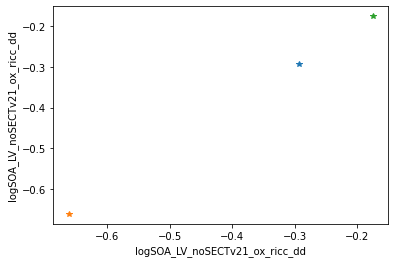

In [66]:
for i,v in enumerate(vars_an):
    print(v,i)
    for j,v2 in enumerate(vars_an):
        print([pca_breast.components_[0][i],pca_breast.components_[0][j]])
        print([pca_breast.components_[1][i],pca_breast.components_[1][j]])
        print([pca_breast.components_[2][i],pca_breast.components_[2][j]])
        
        plt.plot(pca_breast.components_[0][i],pca_breast.components_[0][j], label='pca0', marker='*' )
        plt.plot(pca_breast.components_[1][i],pca_breast.components_[1][j], label='pca1', marker='*' )
        plt.plot(pca_breast.components_[2][i],pca_breast.components_[2][j], label='pca2', marker='*' )
        plt.ylabel(v2)
        plt.xlabel(v)
        plt.show()

In [68]:
principal_breast_Df = pd.DataFrame(data = principalComponents_breast
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

In [69]:
principal_breast_Df.tail()

,principal component 1,principal component 2,principal component 3
2975240,0.906356,-2.230735,-0.555545
2975241,1.812032,-2.190299,-0.569384
2975242,4.144457,-2.621179,-0.669572
2975243,2.859908,-2.053936,-0.336792
2975244,2.144756,-1.488694,-0.463633


In [70]:
print('Explained variation per principal component: {}'.format(pca_breast.explained_variance_ratio_))

Explained variation per principal component: [0.56905081 0.21138857 0.13897482]


In [71]:
pca_breast.components_

array([[-0.45035732, -0.48158246, -0.23743564, -0.43137193, -0.4869185 ,
        -0.29276246],
       [ 0.42278054, -0.34306487,  0.33713448,  0.36373335, -0.14050981,
        -0.6617091 ],
       [ 0.17075154,  0.09107723, -0.88817185,  0.37584767, -0.04267738,
        -0.17497659]], dtype=float32)

<Figure size 432x288 with 0 Axes>

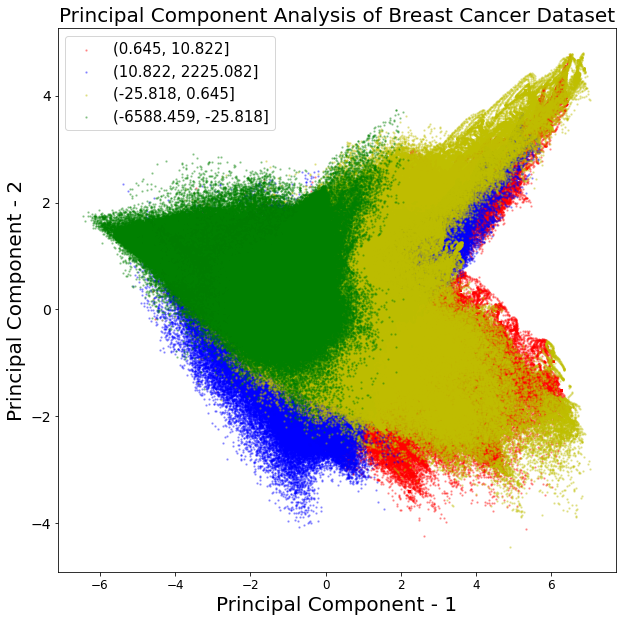

In [72]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = _df['NCONC_cat'].unique()
colors = ['r','b','y','g']
#colors = ['r', 'g']
#plt.scatter(principal_breast_Df['principal component 1']
#            , principal_breast_Df['principal component 2'], c=_df['NCONC01'])
for target, color in zip(targets,colors):
    indicesToKeep = _df['NCONC_cat'] == target
    plt.scatter(principal_breast_Df.loc[indicesToKeep.values, 'principal component 1']
               , principal_breast_Df.loc[indicesToKeep.values, 'principal component 2'], c = color, alpha=0.3, s = 2)
plt.legend(targets,prop={'size': 15})

<Figure size 432x288 with 0 Axes>

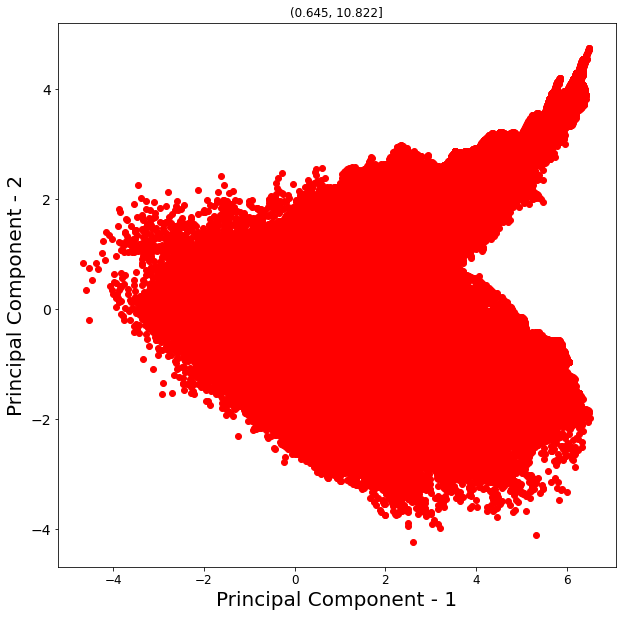

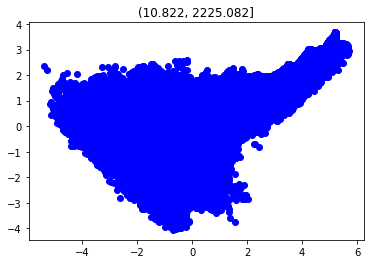

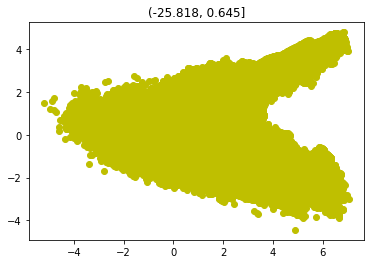

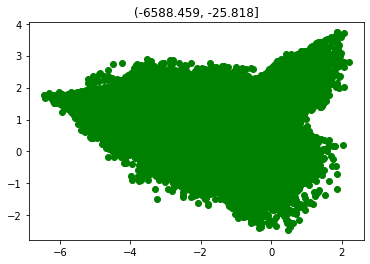

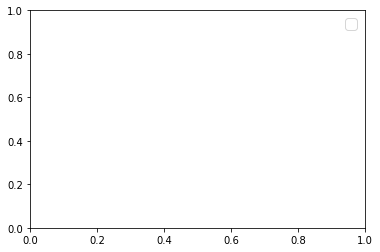

In [222]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = _df['NCONC_cat'].unique()
colors = ['r','b','y','g']
#colors = ['r', 'g']
#plt.scatter(principal_breast_Df['principal component 1']
#            , principal_breast_Df['principal component 2'], c=_df['NCONC01'])
for target, color in zip(targets,colors):
    indicesToKeep = _df['NCONC_cat'] == target
    plt.scatter(principal_breast_Df.loc[indicesToKeep.values, 'principal component 1']
               , principal_breast_Df.loc[indicesToKeep.values, 'principal component 2'], c = color)#, s = 50)
    plt.title(target)
    plt.show()
plt.legend(targets,prop={'size': 15})

In [60]:
_df['NCONC01'].describe()#.mi()

count    3.649536e+06
mean    -3.576676e+01
std      1.768819e+02
min     -6.588458e+03
25%     -1.926724e+01
50%      1.312853e+00
75%      1.184971e+01
max      2.225082e+03
Name: NCONC01, dtype: float64

In [29]:
_das.values

(4, 3649536)

In [43]:
np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]]).shape

(6, 2)

In [49]:
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()
breast_data = breast.data
breast_labels = breast.target
labels = np.reshape(breast_labels,(569,1))
final_breast_data = np.concatenate([breast_data,labels],axis=1)

In [40]:
import numpy as np
from sklearn.decomposition import PCA
X = _das.values.transpose()# np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

pca = PCA(n_components=2)
pca.fit(X)
PCA(n_components=2)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.95723406 0.03730736]
[823259.06 162526.7 ]


In [42]:
pca.components_

array([[-3.6708558e-01,  9.3018663e-01,  2.8642942e-04,  1.0955447e-03],
       [ 9.3018264e-01,  3.6708641e-01,  1.4545878e-03, -2.3523008e-03]],
      dtype=float32)

In [11]:
import importlib as il
from useful_scit.util import conditional_stats
il.reload(conditional_stats)
def _plt_2dhist(ds_diff, xvar, yvar, nr_bins=40, yscale='symlog', xscale='log',
                xlim = [1e-6,1e-2],ylim=[5.,1e3], ax=None):
    """
    xvar = f'NUCLRATE_{case_orig}'
    yvar='NCONC01'
    xlim = [1e-6,1e-2]
    ylim=[1,1e3]
    nr_bins = 40
    yscale='symlog'
    xscale='log'
    """
    varList = [xvar, yvar]#f'NUCLRATE_{case_orig}',f'logNUCLRATE_{case_orig}',f'logSOA_LV_{case_orig}',f'logH2SO4_{case_orig}',f'logNCONC01_{case_orig}',f'logN_AER_{case_orig}',f'N_AER_{case_orig}',f'H2SO4_{case_orig}','NCONC01']
    dims = tuple(ds_diff[varList].dims)
    _ds_s = ds_diff[varList].stack(ind=dims)#('lat','lon','lev','time'))


    ybins = mk_bins(ylim[0], vmax = ylim[1], nr_bins=nr_bins, scale=yscale)
    xbins = mk_bins(xlim[0],vmax=xlim[1], nr_bins=nr_bins, scale=xscale)
    data=_ds_s.to_dataframe()
    lim=0
    #data = -data[(data['NCONC01']<lim)]# | (data['NCONC01']>=lim)]
    x=data[xvar]#f'NUCLRATE_{case_orig}']
    y=data[yvar]#'NCONC01']
    if ax is None:
        fig, ax = plt.subplots(1)
    h =ax.hist2d(x,y,bins=[xbins,ybins], cmap='Reds')#,extent=[-3,3,-300,20],yscale='symlog')

    plt.colorbar(h[3], ax=ax, format = OOMFormatter(4, mathText=False))

    #cb = fig.colorbar(c, ax=ax)
    ax.set_yscale('symlog', linthreshy=ylim[0], linscaley=ylim[0]/10,subsy=[2,3,4,5,6,7,8,9])
    yt = ax.get_yticks()
    ml = np.abs(yt[yt!=0]).min()
    ytl = yt
    ytl[(yt==ml)|(yt==-ml)]=None
    ax.set_yticks(ticks=yt)#[y for y in yt if y!=0])#,
    ax.set_yticklabels(ytl)#[-1e2,-1e1,-1e0,1e0,1e1,1e2])

    #ax.set_yticks([y for y in yt if y!=0])#[-1e2,-1e1,-1e0,1e0,1e1,1e2])
    ax.set_xscale('log')
    return ax
    #plt.show()

def mk_bins(v, vmax = 1e3, nr_bins=20, scale='symlog'):
    if scale=='symlog':
        ybins = np.geomspace(v, vmax, int(nr_bins)/2)
        ybins = ybins - ybins[0]
        ybins = [*-ybins[::-1], *ybins[1:]]
    elif scale=='log':
        ybins = np.geomspace(v, vmax, nr_bins)
    elif scale=='neglog':
        ybins = -np.geomspace(v, vmax, nr_bins)[::-1]

    return ybins


class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

In [12]:
from useful_scit.plot.fig_manip import subp_insert_abc

In [16]:
def _plt_tmp(_ds,axs,var_xl, var_diff, xlims):
    for var,ax in zip(var_xl, axs.flatten()):
        print(var)
        xlim = xlims[var]
        h = _plt_2dhist(_ds,f'{var}_{case_orig}', var_diff,
                nr_bins=40,
                xlim=xlim, ax=ax)
        uni = var_info.get_fancy_unit_xr(_ds[var],
                                     var)
        ax.set_xlabel(f'{get_fancy_var_name(var)} [{uni}]')
        ax.plot(xlim,[0,0], linewidth=.5, c='k')

    uni = var_info.get_fancy_unit_xr(_ds[var_diff],
                           var_diff)
    fvar_diff = get_fancy_var_name(var_diff)
    ylab = f'$\Delta${fvar_diff} [{uni}]'
    for ax in axs[:,0]:
        ax.set_ylabel(ylab)
    
    subp_insert_abc(axs)

    suptit =f'{get_nice_name_case(case_sec)}-{get_nice_name_case(case_orig)} vs.  '
    suptit =f'{fvar_diff}$(m_1)-${fvar_diff}$(m_2)$ vs. $X(m_2)$ \n for $m_1=${get_nice_name_case(case_sec)}, $m_2=${get_nice_name_case(case_orig)}'
    fig.subplots_adjust(hspace=.5, wspace=0.1)#,top=0.8, )
    stit = fig.suptitle(suptit,  fontsize=12, y=.98)
    
    return 

In [50]:
X

array([[-1, -1],
       [-2, -1],
       [-3, -2],
       [ 1,  1],
       [ 2,  1],
       [ 3,  2]])

NUCLRATE
GR
H2SO4
SOA_LV
NCONC01
COAGNUCL


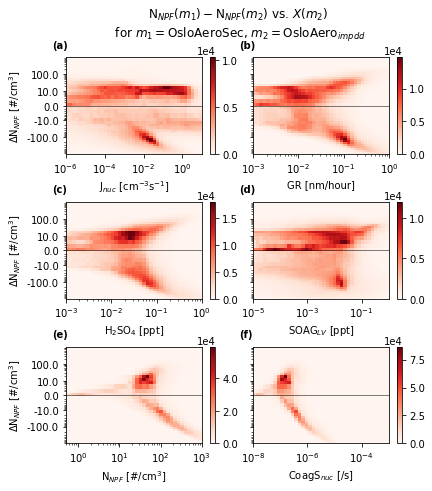

/home/ubuntu/mnts/nird/projects//Plots_OAS-DEV/global_comparison//scatter/2dhist_noSECTv21_ox_ricc_dd_SECTv21_ctrl.


In [17]:
fig, axs = plt.subplots(3,2, figsize=[6.4,7.1], sharey=True)#, constrained_layout=True)
var_xl = ['NUCLRATE','GR','H2SO4','SOA_LV','NCONC01','COAGNUCL']
lev_min=100.
_ds = ds_diff.sel(lev=slice(lev_min, None))
var_diff = 'NCONC01'
xlims = {
    'NUCLRATE' : [1.e-6,10],
    'H2SO4' : [1.e-3,1],
    'SOA_LV' : [1.e-5,1],
    'GR' : [1.e-3,1],
    'N_AER':[1e0,1e4],
    'NCONC01':[5e-1,1e3],
    'COAGNUCL':[1e-8,1e-3],
}

_plt_tmp(_ds,axs,var_xl, var_diff, xlims)
fn = plot_path + f'2dhist_{case_orig}_{case_sec}.'
fig.savefig(fn+'pdf',bbox_extra_artists=(stit,), bbox_inches='tight')
fig.savefig(fn+'png',bbox_extra_artists=(stit,), bbox_inches='tight')
plt.show()
print(fn)